# Predicting the probability that a flight will be delayed

## Objective: 

Have you ever been close to booking an important flight, and wondering whether you will make your connecting flight? Wouldn't it be great to know what the probability of your first flight getting delayed would be, so that you can better plan your layover, and avoid missing your flights? 

That's what this project aim to fix. By using historical flight data, I hope to be able to create a machine learning tool that can help passengers when booking flights, or even airline companies and travel agencies, to reduce the risk of missing a connection. 

## Data 

The data used for this project comes from the Department of Transportation website, which stores flights on-time performance fro 1987 to present. You find find the website link [here](https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018)

For the scope of the project, we will only be looking at all flights in 2018, to make the data size more managable. Additionally, we will only be exploring the patterns of the top 15 busiest airports in the US. Busiest airport was defined based on the "total passenger boarding". The list can be found [here](https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States)

All major domestic US airlines are included in the dataset, and we will look to use them all for exploration, as well as modeling.

## Hypothesis:

* $H_0$: Historical flight delays information is not a helpful feature that can help predict probability of a fligth being delayed.
* $H_a$: Historical flight delays information is a helpful feature that can help predict probability of a flight being delayed.



## Project Phases

The project is broken into two phases. The first phase will look to explore the data, and create a model just using the information provided by the Department of Transportation website. The idea is to be able to develop features that can help the model predict whether a specific airline, or a particular airport, is more prone to experience delays versus others. 

The second phase of the project will look to incorporate weather data, in addition to the information provided by the Department of Transportation. As described in the research paper by S Borsky and C Unterberger$^1$, weather can play a signficant role in flight delays. As such, I hope to incorporate hourly weather data into our dataset, to further explore if there is a relationship, and see if it can be useful for modeling. You can find a link to the paper [here](https://www.sciencedirect.com/science/article/pii/S2212012218300753#sec3).

$^1$Borsky, S and Unterberger, C (2019) ‘Bad weather and flight delays: The impact of sudden and slow onset weather events’, Economics of Transportation, Volume 18.

In [1]:
import pandas as pd
import numpy as np

import os.path
import requests
import io

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

import wrangle
import model
import preprocessing
import explore

# Phase I

## Wrangle

The acquisition of the flight data is relatively easy, as there is in fact datasets already compiled in Kaggle that allow for easy acquistion of the data. [Kaggle Data Link](https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018)

In [2]:
flight_data = pd.read_csv("2018.csv")

In [3]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7213446 entries, 0 to 7213445
Data columns (total 28 columns):
FL_DATE                object
OP_CARRIER             object
OP_CARRIER_FL_NUM      int64
ORIGIN                 object
DEST                   object
CRS_DEP_TIME           int64
DEP_TIME               float64
DEP_DELAY              float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
CRS_ARR_TIME           int64
ARR_TIME               float64
ARR_DELAY              float64
CANCELLED              float64
CANCELLATION_CODE      object
DIVERTED               float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
Unnamed: 27            float64
dtypes: float64(20), int64(3),

In [4]:
flight_data.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2018-01-01,UA,2429,EWR,DEN,1517,1512.0,-5.0,15.0,1527.0,...,268.0,250.0,225.0,1605.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,UA,2427,LAS,SFO,1115,1107.0,-8.0,11.0,1118.0,...,99.0,83.0,65.0,414.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,UA,2426,SNA,DEN,1335,1330.0,-5.0,15.0,1345.0,...,134.0,126.0,106.0,846.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,UA,2425,RSW,ORD,1546,1552.0,6.0,19.0,1611.0,...,190.0,182.0,157.0,1120.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,UA,2424,ORD,ALB,630,650.0,20.0,13.0,703.0,...,112.0,106.0,83.0,723.0,NaN,NaN,NaN,NaN,NaN,NaN


When we first read the data, it comes with flight information for all airports in the US. The data comes with 7.3M rows, and 28 columns. It is taking 1.5GB of memory. Given that large size of the data, and the fact that we want to be able to do efficient exploration and modeling, this is why we will be limiting the size of the data to only the top 15 airports in the US. 

We will use our main wrangle function to read in the clean data. 

In [5]:
flight_data = wrangle.prep_flight_data()

The main steps in the function are as follows:

1. All column names were capitalized, so I lowercase all of the column names.

1. We filter the data based on the airport where the flight is leaving (origin airport). To ensure data integrity, the function runs on a loop, which filters each airport information individually, and then concatenates it to a new dataframe. It is important to note that even though we are only looking at the top airports for departure, all other airports are still included in terms of destinations. Essentially, we are still getting a complete list of flights from the major airports. 

1. Remove null values. Even after filtering for only the top airports, we still had a about 50,000 null values for some rows. After further exploration, I found that the majority of these null values had no departure time / arrival time. I suspect these might have been flights that were cancelled, and as such I decided to drop them.

1. I still had some remaining null values for the reasons why the flights were delayed. After further exploration, I found that all the null values were related to flights not being delayed. As such, I inpuded these null values with `0.0` to indicate that there was no delay.

1. Lastly, the data only shows the airline code (for example, American Airlines is `AA`). In order to better understand what airlines were being referenced, I created a new column that shows the full airline name.

**Data Dictionary:**

* `fl_date`: The day (mm/dd/yyyy) of the flight
* `op_carrier`: The airline carrier code
* `op_carrier_fl_num`: The flight number assigned by the airline carrier
* `origin`: The airport where the flight was departing from
* `dest`: The airport where the flight was arriving
* `crs_dep_time`: The time (24H) that the flight was expected to depart
* `dep_time`: The actual time that the flight departed 
* `dep_delay`: The delay, in minutes, for the flight to depart
* `crs_arr_time`: The expected arrival time
* `arr_time`: The actuall arrival time
* `arr_dealy`: The delay, in minutes, for arrival
* `distance`: The distance, in miles, for that particular flight
* `carrier_delay`: If delayed, the number of minutes this fligth was delayed due to the airline carrier issue
* `weather_delay`: If delayed, the number of minutes this fligth was delayed due to weather
* `nas_delay`: If delayed, the number of minutes this fligth was delayed due traffic control
* `security_delay`: If delayed, the number of minutes this fligth was delayed due security concerns 
* `late_aircraft_delay`: If delayed, the number of minutes this fligth was delayed due the incoming airplane arriving late
* `Airline`: The full name of the airline carrier

In [6]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965760 entries, 0 to 2965759
Data columns (total 18 columns):
fl_date                object
op_carrier             object
op_carrier_fl_num      int64
origin                 object
dest                   object
crs_dep_time           int64
dep_time               float64
dep_delay              float64
crs_arr_time           int64
arr_time               float64
arr_delay              float64
distance               float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
Airline                object
dtypes: float64(10), int64(3), object(5)
memory usage: 407.3+ MB


In [7]:
flight_data.head()

,fl_date,op_carrier,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_time,arr_delay,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,Airline
0,2018-01-01,UA,2429,EWR,DEN,1517,1512.0,-5.0,1745,1722.0,-23.0,1605.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.
1,2018-01-01,UA,2427,LAS,SFO,1115,1107.0,-8.0,1254,1230.0,-24.0,414.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.
2,2018-01-01,UA,2424,ORD,ALB,630,650.0,20.0,922,936.0,14.0,723.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.
3,2018-01-01,UA,2422,ORD,OMA,2241,2244.0,3.0,14,3.0,-11.0,416.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.
4,2018-01-01,UA,2421,IAH,LAS,750,747.0,-3.0,916,900.0,-16.0,1222.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.


After we clean the data, we now have about 3M rows, and 18 columns. The data is still very large, but it is more manageble. That concludes our data acquisiton and prep. We are now ready to move onto exploration.

## Exploration

We will look to understand if there are any patterns that can help us predict if a flight will be delayed.

The objective is to see if there are significantly different groupings based on our target variable, as these would be extremly useful for modeling.

## What percentage of flights experience delays?

In [8]:
print(f"{(flight_data.arr_delay > 0).mean():.0%} of flights experienced a delay in 2018")

37% of flights experienced a delay in 2018


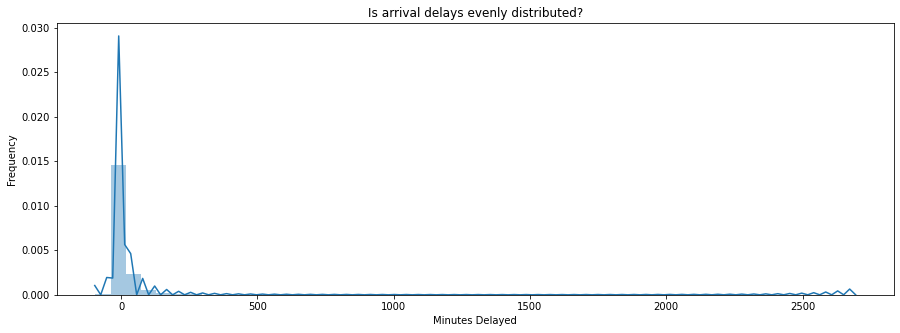

In [9]:
explore.data_distribution(flight_data)

As we can see, the data is infact not normally distributed. This means that there are a lot of outliers. I won't remove the ourliers at this point, however, as we want to preserve as many data points as possible, particularly for the time series exploration. If we find that they are skewing the data too much, we will look to remove them using the IQR method.


This will likely have an effect on any statistical testing, however, as these tests assume that the data is normally distributed.

## What airline carrier experiences the most delays?

* $H_0$: There is no difference in mean between all the carriers in avg minutes of delays
* $H_a$: There is a difference in mean between all the carriers in avg minutes of delays

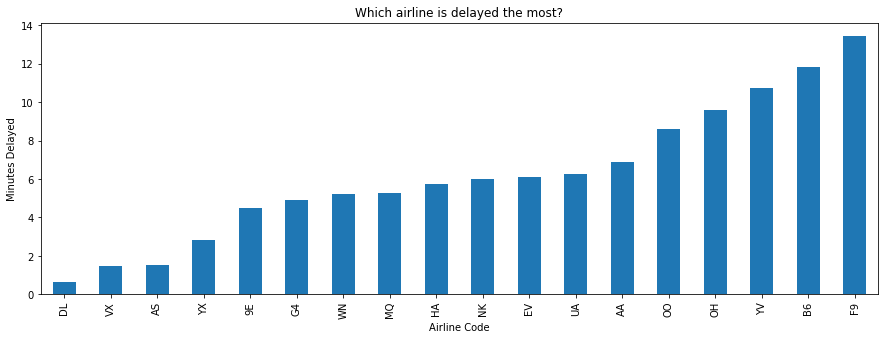

In [10]:
explore.delay_by_airline_minutes(flight_data)

It seems that Frontier had the longest delays, with an average of 13 min delay across 2018. Delta had the overall smallest delays in minutes, with an average of 0.6 min for 2018.

Given that there are 18 unique airlines, we will not perform an ANOVA test, an instead will assume that the data is significant. Given the evidence in the graph, and the fact that we have nearly 2 million datapoints, I suspect we would get a very low p value anyways.

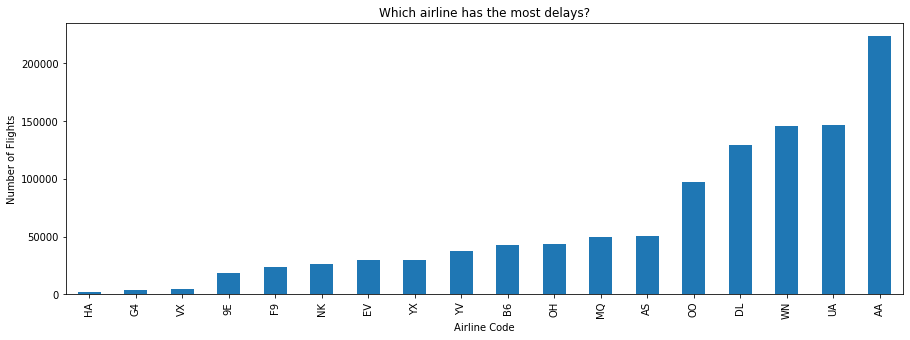

In [11]:
# Delays by flights (count)

explore.delay_by_airline_flights(flight_data)

Interestingly, American Airlines seems to have the most flights delayed. I think this is more indicative of which airlines have most scheduled flights. If we want to look at better metric of delays, we should use minutes delayed.

## What airport experience the most delays?

* $H_0$: There is no mean difference in minutes delayed by airport
* $H_a$: There is a difference in minutes delayed by airport

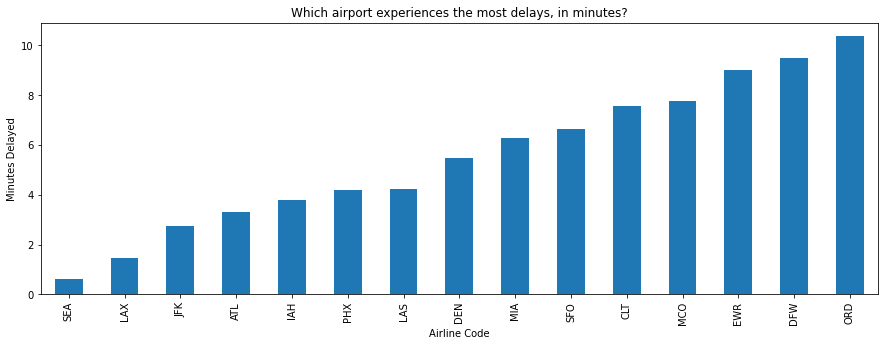

In [12]:
explore.delay_by_airport_minutes(flight_data)

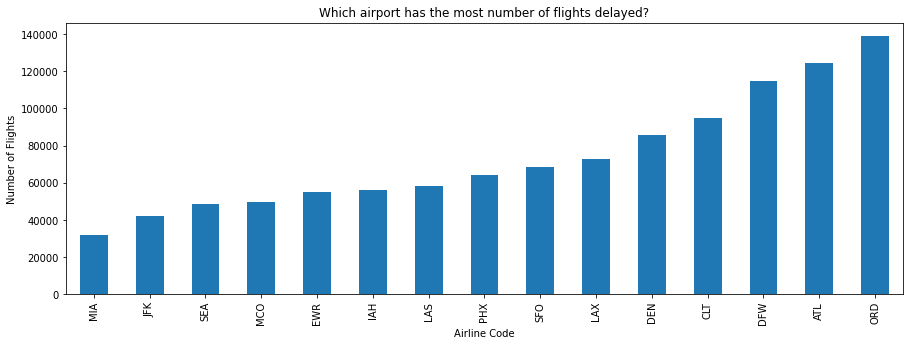

In [13]:
explore.delay_by_airport_flights(flight_data)

Interestingly, Orland seems to have the most delays both in number of flights delayed by more than a minute, and avg minutes delayed. Some ideas that might help explain these results:

1. Look at airports that recieve the most international flights
1. Look at what airports have hubs for what airlines. Given that we know that overall some airlines have a higher propensity to experience delays, it might be that this has an effect on delays by airports.

I initially though that weather might have an impact on this - as Orlando could experience high humidity, however Miami is on the other side of the spectrum, and I would suspect they would have similar weather.

We know Atlanta and LAX are the busiest airports in terms of total number of flights.

Again, given that there are 15 unique airports, we won't conduct an ANOVA test. We will assume that the data is statistically significant.

## What is the most common type of delay?

* $H_0$: There is no difference in mean minutes delayed between the different delay types
* $H_a$: There is a difference in mean minutes delayed between the different delay types

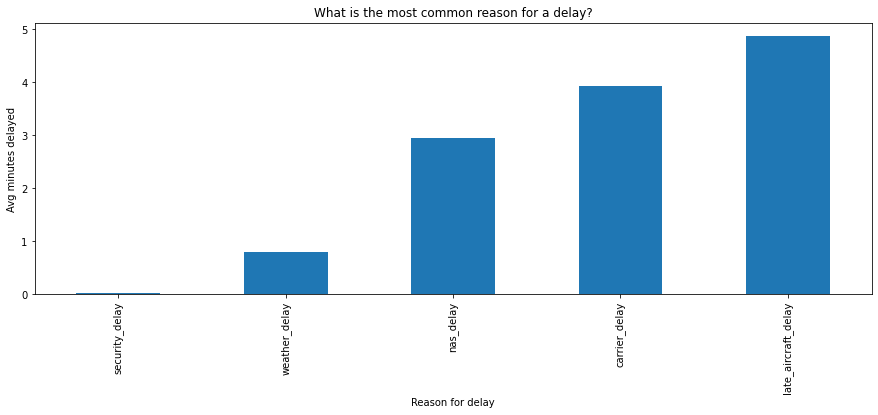

In [14]:
explore.most_common_reason_for_delay(flight_data)

It seems that a late aircraft arrival is the main cause for delays. This raises more questions, as now we may have to not only look at the weather and factor of the previous flights (which means we will need to definitively look at the flight number). 

We might be able to use this information to track inbound [flights]https://flightaware.com/live/flight/UAL208/history/20200709/2205Z/KATL/KIAH

If we could find a way to actually scrape the previous airport, we might be able to get additional data to enhance the model's effectiveness.

In [15]:
# ANOVA
stat, pvalue = stats.f_oneway(flight_data.security_delay, flight_data.weather_delay, flight_data.nas_delay, flight_data.late_aircraft_delay)

print(f"p value:{pvalue}")

p value:0.0


Given that our p value is lower than our alpha, we can reject the null hypothesis, and assume that there is a significant difference between the groups.

## Are delays more or less common when the destination is another major airport?

* $H_0$: The airport destination does no make a mean difference in minutes delayed
* $H_a$: The airport destination does make a mean difference in minutes delayed

$\alpha$ = 0.05

In [16]:
explore.delays_by_destination(flight_data)

Top airport's had an average of 6 minutes when flying to other top airports
Top airport's had an average of 6 minutes when flying to non-top airports


In [17]:
subgroup_1 = flight_data[flight_data.is_top].arr_delay
subgroup_2 = flight_data[~flight_data.is_top].arr_delay

tstat, p = stats.ttest_ind(subgroup_1, subgroup_2)

print(f"p value: {p:.2f}")

p value: 0.00


As we can see, our p value is smaller than our alpha, and as such we can reject the null hypothesis. In this case, we can assume that if the destination airport is another major airport, we can expect higher delayes. This, however, should be taken with some caution, as we are dealing with a very high number of data points, and this could have an influence on the test.

## Is there a time series element to delays?

Elements to look for:

* Yearly seasonality
* Month
* Day of week
* Hourly

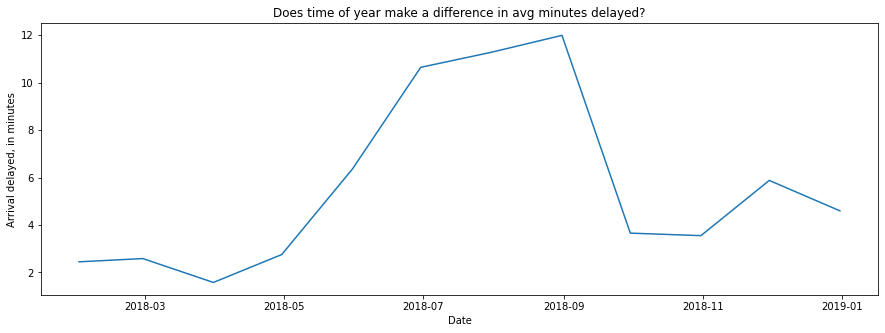

In [18]:
explore.time_of_the_year_delays(flight_data)

We see that there ceirtainly seems to be a seasonality that could be impacting flight delays. It seems that over the summer is when delayes peak. This is likely related to an increase in travel from school breaks as well as summer holidays. We do see a small spike in December, which likely shows people traveling for Christmas. 

## Is there a difference in day of the week delay?

* $H_0$: There is no mean difference in arrival delays between the days of the week
* $H_a$: There is a mean difference in arrival delays between the days of the week

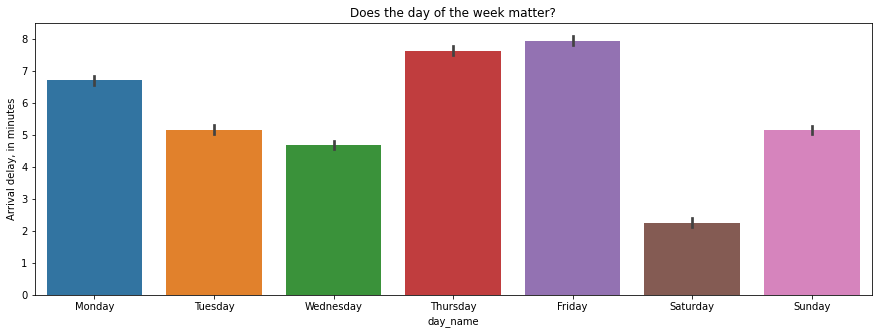

In [19]:
explore.day_of_the_week_delays(flight_data)

In [20]:
explore.anova_test_difference_in_day_of_week(flight_data)

p value: 0.0


Given that our p value is zero, we can reject the null hypothesis, and assume that there is a significant difference in the day of the week and the avg minutes of delays.

It seems that there is ceirtainly some big difference, with Saturday experiencing the least number of delays, and Thursday and Friday having the most. This kind of makes sense, as you would expect most people to travel on a Thursday or Friday (to take advantage of the long weekends) and then return Sunday. Satuday is likely on of the least traveled days.

## Is there a difference in avg minutes delay based on the time of day?

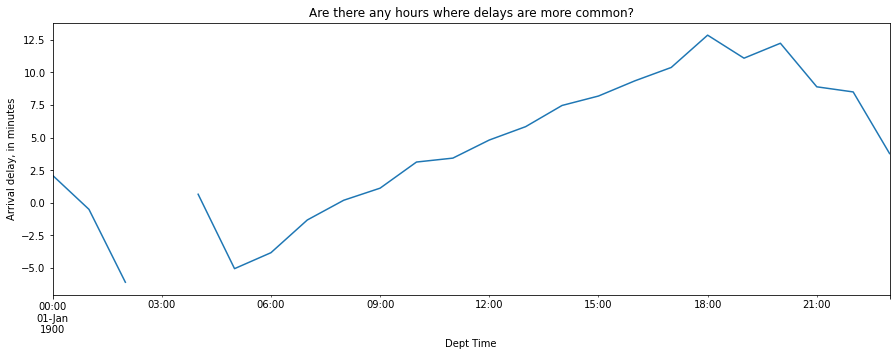

In [21]:
explore.time_of_the_day_delays(flight_data)

It seems that the flights that get most delayed are those in the afternoon, between 4 pm and 9 pm. It also seems that there are no flights between 2 am and 4 am. It seems that there seems to be a small peak in delays at around the time when the airpot opens.

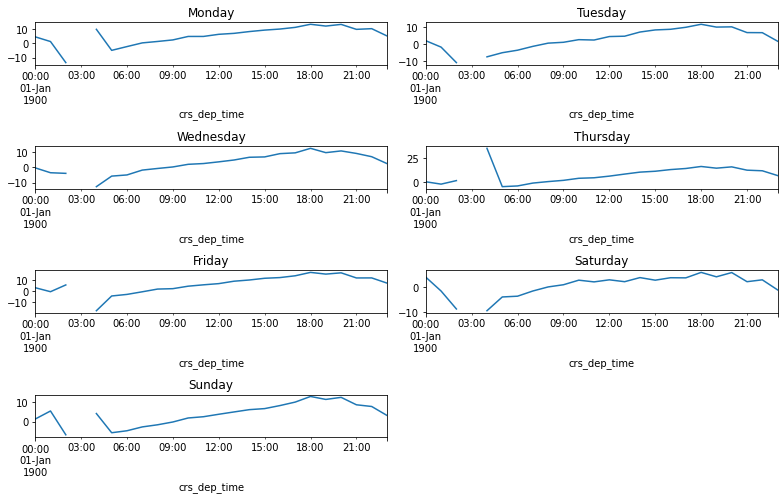

In [22]:
explore.daily_time_of_day_delays(flight_data)

As we can see - it seems that regarless of the day of the week, it seems that the peak in delays is always in the evening, between 6 pm and 9 pm. The only exeption is Thursdays, which suprisingly has a long delays at 4 am. I suspect this is one outlier that is pushing the data towards a peak.

## What percentage of flights had a delayed departure, but still reached their destination on time?

In [23]:
print(f"{((flight_data.dep_delay > 0) & (flight_data.arr_delay <= 0 )).mean():.0%} of flights that are delayed still reach their destination")

10% of flights that are delayed still reach their destination


In [24]:
# What is the max delay that still can reach destination on time? 

flight_data[(flight_data.dep_delay > 0) & (flight_data.arr_delay <= 0 )][["fl_date", "op_carrier", "origin", "dest", "crs_dep_time", "dep_delay", "arr_delay"]].nlargest(5, columns="dep_delay")

,fl_date,op_carrier,origin,dest,crs_dep_time,dep_delay,arr_delay
2077240,2018-09-12,DL,JFK,SFO,1900-01-01 19:25:00,65.0,-1.0
23077,2018-01-03,DL,SEA,KOA,1900-01-01 15:25:00,62.0,-3.0
1540617,2018-07-11,DL,JFK,SFO,1900-01-01 21:00:00,62.0,-1.0
2216828,2018-09-29,DL,SEA,BOS,1900-01-01 15:35:00,62.0,-2.0
154663,2018-01-21,DL,JFK,SFO,1900-01-01 15:25:00,60.0,0.0


It seems that even after a one hour delay, it is still possible to arrive on time. I suspect this has to do with factors other than the ones in this dataset, such as weather conditions, type of plane, length of flight.

Still, it is good to know for modeling purposes.

In [25]:
print(f'''

Flights that departed late by more than one hour were on average {flight_data[(flight_data.dep_delay > 60)][["fl_date", "op_carrier", "origin", "dest", "crs_dep_time", "dep_delay", "arr_delay"]].arr_delay.mean():.0f} minutes late
      
''')



Flights that departed late by more than one hour were on average 126 minutes late
      



In [26]:
print(f'''

Flights that departed late by 30 min were on average {flight_data[(flight_data.dep_delay == 30)][["fl_date", "op_carrier", "origin", "dest", "crs_dep_time", "dep_delay", "arr_delay"]].arr_delay.mean():.0f} minutes late
      
''')



Flights that departed late by 30 min were on average 26 minutes late
      



In [27]:
print(f'''

Flights that departed late by 15 min were on average {flight_data[(flight_data.dep_delay == 15)][["fl_date", "op_carrier", "origin", "dest", "crs_dep_time", "dep_delay", "arr_delay"]].arr_delay.mean():.0f} minutes late
      
''')



Flights that departed late by 15 min were on average 10 minutes late
      



In [28]:
print(f'''

Flights that departed late by 6 min were on average {flight_data[(flight_data.dep_delay == 6)][["fl_date", "op_carrier", "origin", "dest", "crs_dep_time", "dep_delay", "arr_delay"]].arr_delay.mean():.0f} minutes late
      
''')



Flights that departed late by 6 min were on average 1 minutes late
      



We found that on average, flights that departed late by more than 6 minutes were in fact late. As such, when we look to create our target variable, we will use the `arr_delay` feature. 

## Does distance have an impact on the number of delays?

* $H_0$: There is no correlation between distance and the number of minutes a flights gets delayed
* $H_a$: There is a correlation between distance and the number of minutes a flights gets delayed

$\alpha$ = 0.05

In [29]:
# What is the longest flight?

flight_data[["Airline", "origin", "dest", "distance"]].nlargest(1, "distance")

,Airline,origin,dest,distance
2194,Hawaiian Airlines Inc.,JFK,HNL,4983.0


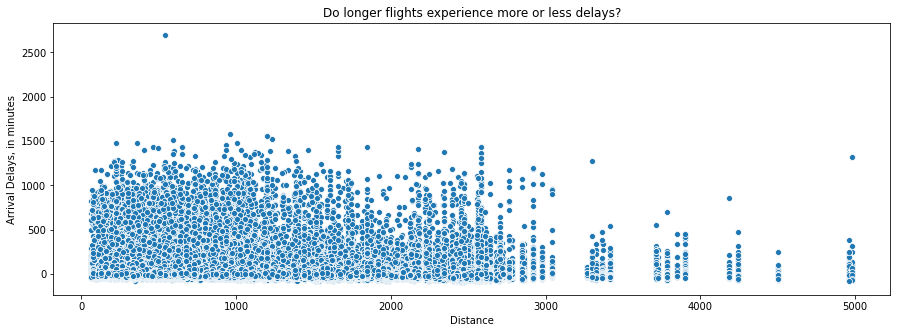

In [30]:
explore.distance_scatterplot(flight_data)

In [31]:
r, p = stats.pearsonr(flight_data.distance, flight_data.arr_delay)

print(f"r value is: {r:.2f}")
print(f"p value is: {p:.2f}")

r value is: -0.03
p value is: 0.00


Because our p value is less than our alpha, we reject the null hypothesis, and conclude that distance and arrival delays do have a correlation. However, when we look at the r value, we see that this is actually a very small negative correlation (meaning that as distance increases, arrival delays decrease).

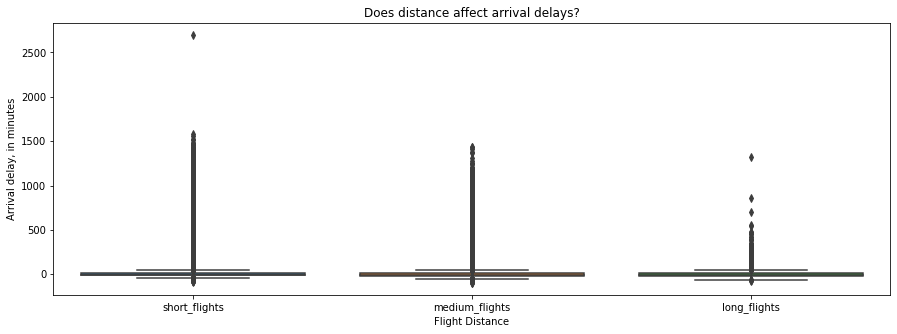

In [32]:
explore.distance_boxplot(flight_data)

It seems that there is overall no major differences in terms of delays. While the majority of the fligts are towards the shorter end, the overall avg minutes delayed seems to be fairly similar. 

With this - I have enough information to move onto a first phase of modeling.

## Preprocessing

Now that we have finished exploration, and have a better idea of what are the best features we can use for modeling, we need to prepare the dataframe into the correct format to feed it to the models.

Given that a lot of our features are categorical (airport name, airline carrier name, ect), we need to figure out a way to encode these features. We could use a `OneHotEncoder`, but that would add a lot of columns, and that could add a lot of complexities. 

As such, a better feature to encode our categorical values would be to use the mean delay, in minutes, for each categorical feature. 

This way, Orlando airport, which has the highest minutes of delays, will have a higher value than other airports. Hopefully, features like this can help the model better understand the historical data and find patterns to predict the likelihood of flights beind delayed. 

The following steps are used by the `mvp_modeling_prep` function to prepare the data for modeling:

1. Read the csv file
1. Add's datetime_features
1. Creates new features using avg_minutes_delay
1. Add's our target value (if the flight's arrival is delayed by 1 minute or more, then it is considered to be a `True` case)
1. Splits the data into a train, validate and test dataframes. 
1. The data is scaled using a `min_max_scaler`

In [33]:
features_for_modeling = ["dest_airport_avg_delay", "carrier_avg_delay", "airport_avg_delay", "crs_dep_time", "crs_arr_time", "month", "day_of_week"]
target_variable = "is_delay"

In [34]:
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = preprocessing.mvp_modeling_prep(modeling=True, features_for_modeling=features_for_modeling, target_variable=target_variable)

In [35]:
train_scaled.shape[0], validate_scaled.shape[0], test_scaled.shape[0]

(1668240, 556080, 741440)

## Modeling

For modeling, we want to create a classification model that can predict the probability that a flight will be delayed. Luckly, because of the nature of our objective, we don't necesarily need have a particularly high accuracy model, as we are simply trying to calculate the probabily of a flight getting delay. 

For the purposes of this project, our true positive value will be if the flight is delay. 

Our confusion matrix will look at following:

|    | Actual Positive | Actual Negative | 
|----|----------------|----------------|
Predicted Positive | Flight predicted late, and arrives late | Flight predicted late, but arrives on time |
Predicted Negative | Flight predicted to be on time, but arrives late | Flight predicted to be on time, and arrived on time |


If we think of our stakeholder, we need to help flight passangers get better insight in how to book their flights. In this case, a false postive (flight predicted late, but arrives on time) is less expensive than a false negative (flight predicted to be on time, but arrives late). The cost of a false positive is a longer layover in an airport, while the cost of a false negative is potentially a missed connection, which can derail an entire trip. As such, we will focus our models to ensure that they have both high accuracy, and a high recall score. Recall score is used to measure the percent of actual positive cases that were predicted as positive, so it will help ensure that our model's are correctly identifying the actual positive values. 

In other to help us compare the different models, we will compare our model scores against a baseline. As it is tranditional when doing classification models, we will use the most common outcome as the baseline.

In [36]:
print(f"{(y_train).mean():.0%} of flights were delayed in 2018")

37% of flights were delayed in 2018


Given that 37% of the flights were late (or positive), we will use `False` as the baseline.

In [37]:
predictions = pd.DataFrame({"actual":y_train, "baseline": False})

### Random Forest

In [38]:
# model.run_rf_loop(train_scaled, validate_scaled, y_validate, y_train, 8)

In [39]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 5)
predictions["random_forest"] = y_pred

In [40]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)

print(accuracy_score)
print(matrix)

report

Accuracy on dataset: 0.63
         False  True 
False  1024892  20841
True    593748  28759


,False,True,accuracy,macro avg,weighted avg
precision,6.331809e-01,0.579819,0.631594,6.064997e-01,6.132687e-01
recall,9.800704e-01,0.046199,0.631594,5.131346e-01,6.315944e-01
f1-score,7.693307e-01,0.085579,0.631594,4.274547e-01,5.141873e-01
support,1.045733e+06,622507.000000,0.631594,1.668240e+06,1.668240e+06


In [41]:
print(f"Accuracy score on validate df: {rf.score(validate_scaled, y_validate):.0%}")

Accuracy Score on validate df: 63%


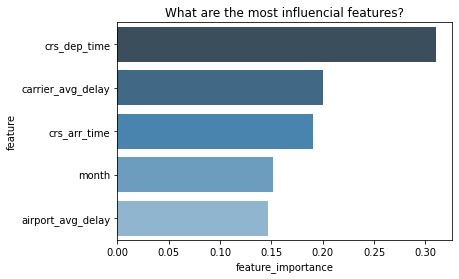

In [42]:
model.rf_feature_importance(rf, train_scaled)

**Takeaways:** The random forest model achieved a 63% accuracy. The model performs very similarly on our validate dataframe, which means that the model is not overfit. It performed better than the baseline, however, it has a very low recall score (less than 1 actually), meaning that the model is not getting a lot of true positives. This means that we probably wouldn't recommend using this model.

On an interesting note, we see that the most influencial feature leading the prediction is the departure time of the flight. We did see that flights are more likely to experience bigger delays during the hours of 7 pm and 11 pm. 

The least influencial values are `day_of_week` and `dest_airport_avg_delay`. 

### KNN

In [43]:
# model.run_knn_loop(train_scaled, validate_scaled, y_validate, y_train, 10)

In [44]:
knn, y_pred = model.run_knn(train_scaled, y_train, 3)
predictions["knn"] = y_pred

In [45]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)

print(accuracy_score)
print(matrix)

report

Accuracy on dataset: 0.67
        False   True 
False  946769   98964
True   444244  178263


,False,True,accuracy,macro avg,weighted avg
precision,6.806327e-01,0.643022,0.674383,6.618273e-01,6.665981e-01
recall,9.053640e-01,0.286363,0.674383,5.958635e-01,6.743826e-01
f1-score,7.770765e-01,0.396257,0.674383,5.866668e-01,6.349730e-01
support,1.045733e+06,622507.000000,0.674383,1.668240e+06,1.668240e+06


In [46]:
print(f"Accuracy Score on validate df: {knn.score(validate_scaled, y_validate):.0%}")

Accuracy Score on validate df: 63%


**Takeaways:** The KNN performs much better. It achieved a 77% accuracy score, and a 41% recall score, which is significantly better than our previous model. The model is a little more overfit, however, as the model did not perform as well on the validate dataset. 

### Gradient Boosting Classifier

In [47]:
gb, y_pred = model.run_gb(train_scaled, y_train)
predictions["gradient_bossting"] = y_pred

In [48]:
accuracy_score, matrix, report = model.accuracy_report(gb, y_pred, y_train)

print(accuracy_score)
print(matrix)

report

Accuracy on dataset: 0.63
         False  True 
False  1045733      0
True    622507      0


,False,True,accuracy,macro avg,weighted avg
precision,6.268481e-01,0.0,0.626848,3.134240e-01,3.929385e-01
recall,1.000000e+00,0.0,0.626848,5.000000e-01,6.268481e-01
f1-score,7.706289e-01,0.0,0.626848,3.853144e-01,4.830672e-01
support,1.045733e+06,622507.0,0.626848,1.668240e+06,1.668240e+06


In [49]:
print(f"Accuracy Score on validate df: {gb.score(validate_scaled, y_validate):0%}")

Accuracy Score on validate df: 62.632355%


------

In [50]:
model.compare_prediction_results_accuracy(predictions)

Accuracy Scores
---------------
Actual = 1.00
Baseline = 0.63
Random_Forest = 0.63
Knn = 0.67
Gradient_Bossting = 0.63


In [51]:
model.compare_prediction_results_other_metrics(predictions, "recall", "True")

Recall Scores
---------------
Actual = 1.00
Baseline = 0.00
Random_Forest = 0.05
Knn = 0.29
Gradient_Bossting = 0.00


**Takeaways:** We see that overall, KNN did the best job. It overall scored the highest accuracy score, and highest recall score.

We will now evaluate the KNN model using the test data, to ensure that the model is not overfit.

## Evaluate

In [52]:
knn, y_pred = model.run_knn(train_scaled, y_train, 3)

In [53]:
y_pred = knn.predict(test_scaled)

In [54]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_test)

print(accuracy_score)
print(matrix)

report

Accuracy on dataset: 0.61
        False   True 
False  335145  129517
True   159247  117531


,False,True,accuracy,macro avg,weighted avg
precision,0.677893,0.475742,0.610536,0.576817,0.602430
recall,0.721266,0.424640,0.610536,0.572953,0.610536
f1-score,0.698907,0.448741,0.610536,0.573824,0.605521
support,464662.000000,276778.000000,0.610536,741440.000000,741440.000000


## Conclusion

It seems that KNN is the best model for this task. We are only able to get a 61% accuracy on our test data, is which is a little less than our baseline. When it comes to recall, our model performs significantly better. However, we defintively want to do better.  

I believe that the reasons why the model is not performing as well is because there are other factors, beyond just those present in the data, that lead to a flight getting delayed. 

As we saw from the data, the missing variables that we could bring in to further improve the model are:

1. Weather data
    * If we could add hourly weather data, we would be able to see if there were any particular weather elements that we can use for modeling.
1. Previous flight information
    * We saw that actually the biggest reason for a flight delay is because the plane arrived late. If we could perhaps find a way to actually track that information, we could further enhanced the model. A way to actually accomplish this is to perhaps use the mean delay avg in minutes for the previous flight.
    
That being said, we can reject our main null hypothesis, as we have demonstrated that we can create a model that is more effective than our baseline, using only historical flight information. 

------------

# Phase II

Our objective now is to predict weather a flight will be delayed, while using weather data. Unfortunately, acquiring weather data was a little harder than expected. In order to accomplish our objectives, we needed to acquire weather data that covered all top 15 airports, and the data was recorded on an hourly basis. This was harder to acquire than expected. 

I was able to get a dataset with hourly weather data for cities all over the US. It covered 2018 data range, but it was slighly untraditional, as it didn't include temperature or pressure data, but rather it collected what, if any, weather events the city was expericing. 

The data comes from Kaggle, but it was originally collected by a team at Cornell.$^1$ The following is a description of the weather events captured in the data:

### Hypothesis:

* $H_0$: Weather conditions are not a helpful features that can help predict probability of a fligth being delayed.
* $H_a$: Weather conditions are helpful features that can help predict probability of a fligth being delayed.

**Description of Weather Events**

Weather event is a spatiotemporal entity, where such an entity is associated with location and time. Following is the description of available weather event types in this dataset:

Severe-Cold: The case of having extremely low temperature, with temperature below -23.7 degrees of Celsius.
Fog: The case where there is low visibility condition as a result of fog or haze.
Hail: The case of having solid precipitation including ice pellets and hail.
Rain: The case of having rain, ranging from light to heavy.
Snow: The case of having snow, ranging from light to heavy.
Storm: The extremely windy condition, where the wind speed is at least 60 km/h.
Other Precipitation: Any other type of precipitation which cannot be assigned to previously described event types.


$^1$Moosavi, Sobhan, Mohammad Hossein Samavatian, Arnab Nandi, Srinivasan Parthasarathy, and Rajiv Ramnath. [“Short and Long-term Pattern Discovery Over Large-Scale Geo-Spatiotemporal Data.”](https://arxiv.org/abs/1902.06792) In Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, ACM, 2019.

## Wrangle

In [55]:
weather_data = pd.read_csv("US_WeatherEvents_2016-2019.csv")

In [56]:
weather_data.head()

,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


When we first read the data, it comes in with data that ranges from 2016-2018 and it includes cities all over the US. 

One thing I noticed was that the `AirportCode` didn't necesarly also match the correct `City`. I found that some of the airport codes, like CTL, didn't match Charlotte. To fix for this issue, I used another data set, to match the `AirportCode` in the database and combine it with the `ICAO` airport codes so that I could not only merge it with my flight_data, but also better record what city that the airport belonged to.

The major problem that the data had was that it only had records of precipitation activites. When events were supposed to be clear weather conditions, they weren't recorded. As such, I had to reset the datetime index to ensure that there weren't any time lags in the dataframe. This was a little tricker, given that it had to be done on a city by city basis.

The following steps were needed to make the data usable:

1. Used airport data to add `IATA` codes, so that we could better merge the data in the future
1. Filter for only the top 15 airports, using the `IATA` codes. 
1. Create a loop that goes through data for each city, and individually reset all datetime indexes, so that we have a complete picture of what the weather was like for that city. 
1. The data was in UTC timezone, and so we needed to convert the data into local data, so that it could match our flight information. 
1. Add a unique identifier (primary key) that could be used to combine the weather dataset with the flight information. 

These steps are accomplish by the two functions below

In [59]:
weather_data = wrangle.prep_weather_data()

In [ ]:
weather_data = wragnle.filter_weather_data(weather_data)

In [ ]:
weather_data.head()

As we see, the data now is in a usable format, that can be merged with the flight data set. Each observation is a particular time, day and city. The hours have also been updated to their local timezone.

Now that the data is in the correct format, we are ready to merge the data with the flight dataframe

In [ ]:
merged_df = wrangle.merge_flight_weather_data()

In [ ]:
merged_df.head()

We now have an effective dataframe that we can use for exploration and modeling. 

Each observation of the data contains:

1. A time and date
1. an airline and flight number for a particular flight
1. The airport where the flight is departing from
1. The airport where the flight is flying to
1. The number of minutes the flight was delay at departure and/ arrival
1. The type of precipitation (and intencity) that the partilar departing airport was experincing at a specific day and time

With these values, we are ready to move onto exploration

## Exploration



In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(data=merged_df,x="Type", y="arr_delay", ci=False)
plt.title("What type of precipitation leads to most delays?")
plt.ylabel("Number of minutes delayed")
plt.xlabel("Type of Weather")

Interesting - it seems that storms lead to the total highest minutes in delays, followed by snow. Extremely cold temperatures seems to have the lowerst number of delays, as well as clear skys.

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=merged_df,x="Type", y="arr_delay")
plt.title("What type of precipitation leads to most delays?")
plt.ylabel("Number of minutes delayed")
plt.xlabel("Type of Weather")

There are clearly some really high outliers - but overall, Storm stills seems to have the biggest average, closely followed perhaps by precipitation. 

On a positive note, we have evidence that weather isn't the only reason a plane is delayed, as we still see delays when the sky's are clear, however, they are clearly the minority, so we can hopefuly expect the model will greatly improve with this tipe of information.

In [ ]:
# does the weather severity play a role?

plt.figure(figsize=(15,5))
sns.barplot(data=merged_df, y="arr_delay", x="Severity", ci=False)
plt.title("Does weather severity play a role in delays?")

In [ ]:
severity = merged_df.Severity.unique()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

for count, i in enumerate(severity):
     
    data = merged_df[test.Severity == i]
    plt.subplot(3, 3, count + 1)
    sns.barplot(data=data, x="Type", y="arr_delay", ci=False)
    plt.title(f"{i}")
    fig.tight_layout()
    
plt.show()

Interestingly, we see that actually `heavy` precipiation seems to cause the most delays, with `Heavy Snow` causing the greatest delays.

## Preprocessing

In [60]:
features_for_modeling = ["dest_airport_avg_delay", "avg_type_severity", "carrier_avg_delay", "airport_avg_delay", "crs_dep_time", "crs_arr_time", "month", "day_of_week"]
target_variable = "is_delay"

In [61]:
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = preprocessing.weather_modeling_prep(modeling=True, features_for_modeling=features_for_modeling, target_variable=target_variable)

In [62]:
train_scaled.shape[0], validate_scaled.shape[0], test_scaled.shape[0]

(1668247, 556083, 741444)

In [63]:
train_scaled

,dest_airport_avg_delay,avg_type_severity,carrier_avg_delay,airport_avg_delay,crs_dep_time,crs_arr_time,month,day_of_week
2018-05-13_NK_1090,0.426594,0.050299,0.420473,0.909610,0.338846,0.475198,0.363636,1.000000
2018-05-20_UA_1682,0.313407,0.146900,0.439076,1.000000,0.531807,0.593581,0.363636,1.000000
2018-11-22_DL_1354,0.353418,0.114137,0.000000,0.083960,0.989822,0.266778,0.909091,0.500000
2018-07-02_AA_1765,0.398811,0.044873,0.486026,1.000000,0.211620,0.263026,0.545455,0.000000
2018-09-29_AA_517,0.338200,0.047391,0.486026,0.909610,0.644190,0.774073,0.727273,0.833333
...,...,...,...,...,...,...,...,...
2018-02-06_UA_1884,0.325157,0.044873,0.439076,0.323935,0.773961,0.879533,0.090909,0.166667
2018-01-02_DL_1550,0.351375,0.044873,0.000000,0.272249,0.472010,0.518549,0.000000,0.166667
2018-07-27_OH_5251,0.354454,0.040272,0.699364,0.711545,0.531383,0.563568,0.545455,0.666667
2018-07-18_B6_1183,0.426594,0.044873,0.873543,0.215099,0.556828,0.671530,0.545455,0.333333


## Modeling

In [64]:
predictions = pd.DataFrame({"actual":y_train, "baseline": False})

### Random Forest

In [65]:
# model.run_rf_loop(train_scaled, validate_scaled, y_validate, y_train, 8)

In [66]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 3)
predictions["random_forest"] = y_pred

In [67]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)

print(accuracy_score)
print(matrix)

report

Accuracy on dataset: 0.63
         False  True 
False  1041960   3066
True    616401   6820


,False,True,accuracy,macro avg,weighted avg
precision,6.283071e-01,0.689864,0.628672,6.590858e-01,6.513036e-01
recall,9.970661e-01,0.010943,0.628672,5.040046e-01,6.286719e-01
f1-score,7.708552e-01,0.021545,0.628672,3.961999e-01,4.909290e-01
support,1.045026e+06,623221.000000,0.628672,1.668247e+06,1.668247e+06


In [68]:
rf.score(validate_scaled, y_validate)

0.6307241904535834

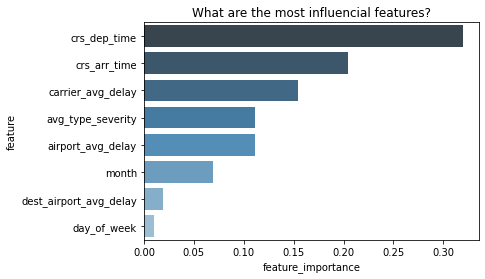

In [69]:
model.rf_feature_importance(rf, train_scaled)

### KNN

In [70]:
# model.run_knn_loop(train_scaled, validate_scaled, y_validate, y_train, 10)

In [71]:
knn = KNeighborsClassifier(n_neighbors=3, weights='uniform')

In [72]:
knn.fit(train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [73]:
y_pred = knn.predict(train_scaled)
predictions["knn"] = y_pred

In [74]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)

print(accuracy_score)
print(matrix)

report

Accuracy on dataset: 0.79
        False   True 
False  908482  136544
True   210572  412649


,False,True,accuracy,macro avg,weighted avg
precision,8.118303e-01,0.751373,0.791928,7.816019e-01,7.892449e-01
recall,8.693391e-01,0.662123,0.791928,7.657311e-01,7.919277e-01
f1-score,8.396011e-01,0.703931,0.791928,7.717658e-01,7.889175e-01
support,1.045026e+06,623221.000000,0.791928,1.668247e+06,1.668247e+06


In [75]:
knn.score(validate_scaled, y_validate)

0.6132016263759187

### Gradient Boosting Classifier

In [76]:
gb, y_pred = model.run_gb(train_scaled, y_train)
predictions["gradient_boosting"] = y_pred

In [77]:
accuracy_score, matrix, report = model.accuracy_report(gb, y_pred, y_train)

print(accuracy_score)
print(matrix)

report

Accuracy on dataset: 0.63
         False  True 
False  1041976   3050
True    614272   8949


,False,True,accuracy,macro avg,weighted avg
precision,6.291183e-01,0.745812,0.629958,6.874652e-01,6.727126e-01
recall,9.970814e-01,0.014359,0.629958,5.057203e-01,6.299577e-01
f1-score,7.714701e-01,0.028176,0.629958,3.998231e-01,4.937915e-01
support,1.045026e+06,623221.000000,0.629958,1.668247e+06,1.668247e+06


In [78]:
gb.score(validate_scaled, y_validate)

0.6320495321741538

In [79]:
# How do the different models compare on accuracy?
print("Accuracy Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report.accuracy[0]:.2f}')

Accuracy Scores
---------------
Actual = 1.00
Baseline = 0.63
Random_Forest = 0.63
Knn = 0.79
Gradient_Boosting = 0.63


In [80]:
# How do the different models compare on recall?
print("Recall Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report["True"].loc["recall"]:.2f}')

Recall Scores
---------------
Actual = 1.00
Baseline = 0.00
Random_Forest = 0.01
Knn = 0.66
Gradient_Boosting = 0.01


In [81]:
# How do the different models compare on recall?
print("Precision Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report["True"].loc["precision"]:.2f}')

Precision Scores
---------------
Actual = 1.00
Baseline = 0.00
Random_Forest = 0.69
Knn = 0.75
Gradient_Boosting = 0.75


## Evaluate

In [82]:
knn, y_pred = model.run_knn(train_scaled, y_train, 2)

In [83]:
y_pred = knn.predict(test_scaled)

In [84]:
accuracy_score, matrix, report = model.accuracy_report(gb, y_pred, y_test)

print(accuracy_score)
print(matrix)

report

Accuracy on dataset: 0.63
        False  True 
False  404562  59697
True   214616  62569


,False,True,accuracy,macro avg,weighted avg
precision,0.653386,0.511745,0.630029,0.582565,0.600434
recall,0.871414,0.225730,0.630029,0.548572,0.630029
f1-score,0.746812,0.313275,0.630029,0.530044,0.584737
support,464259.000000,277185.000000,0.630029,741444.000000,741444.000000


**Takeaway:** As we can see - it seems that weather conditions doesn't greatly help us improve our models. Overall, the KNN was still the best performing model, however, when we look to create the models, they are either greatly overfit, or they don't perform better than the baseline. 

It is surprising, given the research that I found, that weather wouldn't help us better predict flight delays. I suspect that the reason why our models are not as effective is due to the type of weather data that was used, as well as the number of airports we used in our scope. 

Given that some airports would be better equiped to deal with ceirtain weather problems depending on their location, this could be causing a problem with the models. For example, we saw that snow can be one of the biggest factors for flight delays, however airports like Chicago or Denver might be better equiped to deal with snow, and as a results, we may not see delays in these airports. This might confuse the model, as it makes it look like snow perhaps doesn't have a big impact in flight delays, and as such, it gives the features less priority. 

In order to try to improve the model, I will create a separate model for each airport, so that each airport can be analyzed individually. We can then aggregate the scores to compare them against our existing models. This will also greatly help in improving the speed of the GUI / Flask app, as it will reduce the time needed for the model to be fitted. 

### Individual Models

Given that KNN has consistently been the best performing model, we will just look to fit our individual models with a KNN, with a K-neighbors of 3. 

The function below, called `model_airports_individually` actually masks the dataframe for each individual airport, and create's models for each. For the purposes of evaluating the effectiveness of the models, we collect the scores. The models are fitted using `train_data`, but the scores we see below are based on how the model performs using `test_data`.

In [85]:
features_for_modeling = ["dest_airport_avg_delay", "avg_type_severity", "carrier_avg_delay", "airport_avg_delay", "crs_dep_time", "crs_arr_time", "month", "day_of_week"]
target_variable = "is_delay"

In [86]:
score = model.model_airports_individually(features_for_modeling, target_variable)

In [88]:
score.loc["accuracy"].mean()

0.6057530606054229

In [89]:
score.loc["recall"].mean()

0.4148794325324767

Overall, it seems that when modeled individually, the models do performs just about the same our our initial, Phase I models. While it is still not as effective in terms of accuracy, the model still performs at around 41% recall. 

I recommend using these individually fitted models. While it might not be more effective, it will be significantly faster from a processing point of view to make a prediction if the data is filtered down. 

------

# Conclusion



Overall, we found that we can effectively use historical and weather data to predict flight delays with higher recall scores than our baseline. 

However, I found that there might be a key element missing in the data to more effectively predict flight delays. The biggest suspect at the moment is the fact that my data isn't showing the probability that the plane for that flight arrives late. As we saw from the exploration, late plane arrival is the biggest cause for delays. If there was a way for us to calculate where the previous flights were coming from, or at least the avg time it arrives late, I think we can have a far more effective model.

Below is the function we will use to fit and create a prediction:

In [91]:
airline = "AA"
flight_number = "1988"
date = "07/20/2020"
dep_airport = "CTL"
arr_airport = "SAT"
dep_time = "11:19"
arr_time = "13:01"

In [ ]:
merged_df = wrangle.merge_flight_weather_data()
merged_df = preprocessing.to_date_time(merged_df)
merged_df = preprocessing.create_new_features(merged_df)
merged_df = preprocessing.create_target_variable(merged_df)

# add weather features
merged_df["avg_weather_delay"] = merged_df.groupby("Type").arr_delay.transform("mean")
merged_df["type_severity"] = merged_df.Type + "_" + merged_df.Severity
merged_df["avg_type_severity"] = merged_df.groupby("type_severity").arr_delay.transform("mean")

merged_df = merged_df[(merged_df.op_carrier == airline)]

merged_df = merged_df[features_for_modeling]
merged_df = merged_df.set_index("observation")

train, validate, test = preprocessing.split_data(merged_df)

X_train = train.drop(columns=target_variable)
y_train = train[target_variable]
X_validate = validate.drop(columns=target_variable)
y_validate = validate[target_variable]
X_test = test.drop(columns=target_variable)
y_test = test[target_variable]

scaler, train_scaled, validate_scaled, test_scaled = preprocessing.min_max_scaler(X_train, X_validate, X_test)

knn, y_pred = run_knn(train_scaled, y_train, 3)
y_pred = knn.predict(test_scaled)
report = classification_report(y_test, y_pred, output_dict = True)
report = pd.DataFrame.from_dict(report)
actual_score = pd.DataFrame({airline: [report.accuracy.values[0], report["True"].loc["recall"]]}, index=["accuracy", "recall"])

score = pd.concat([score, actual_score], axis=1)